## Часть 1
Напишите скрипт, который скачивает все данные с выборов губернатора СПб 2019г для всех избирательных участков. 

Входная точка [по ссылке](http://notelections.online/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222). Затем нужно перейти на сайты территориальных избирательных комиссий. Результаты нужно сохранить в  `cvs`-файл, `sqlite` базе данных или `parquet`-файле. В итоге должна получиться таблица с полями:
- название ТИК (территориальная избирательная комиссия, некоторое объединение избирательных участков на определенной территории)
- номер УИК (избирательный участок)
- 14 стандартных полей из итогового протокола

Скрипт должен быть в отдельном `*.py` файле или в отдельном `jupyter`-ноутбуке. 

In [1]:
import lxml.html
import requests
from bs4 import BeautifulSoup
import csv
import os
import re
import pandas as pd

URL = 'http://notelections.online/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222'
HOST = 'http://notelections.online'

def get_html(url):
    r = requests.get(url)
    return r

html = get_html(URL)
soup = BeautifulSoup(html.text, 'html.parser')
links_in_html = soup.find_all('a', href=True)
good_links = []

for link in links_in_html:
    if link['href'].startswith('/region/region/st-petersburg') and link['href'].endswith('222'):
        good_links.append(HOST + link['href'])
del(links_in_html)

def parse(html,n_tik):    
    def extract_values(row):
        values = []
        row_values = row.find_all('td')
        for row_value in row_values:
            values.append(int(re.findall(r'\d+',row_value.text)[0]))
        return values
    
    soup = BeautifulSoup(html.text, 'html.parser')
    table = soup.find_all('table')[-1]
    rows = table.find_all('tr')
    clear_rows = []
    for i,row in enumerate(rows):
        if i == 12:
            continue
        clear_rows.append(extract_values(row))
    data_tik = pd.DataFrame(data=clear_rows).transpose()
    data_tik['tik'] = [n_tik + 1 for _ in range (len(clear_rows[0]))]
    data_tik['uik'] = [clear_rows[0][i] for i in range(len(clear_rows[0]))]
    data_tik = data_tik[['tik','uik',1,2,3,4,5,6,7,8,9,10,11,12,13,14]]
    return data_tik

list_data_tik = []
for n_tik, link in enumerate(good_links):
    html_tik = get_html(link)
    list_data_tik.append(parse(html_tik,n_tik))

data = pd.concat(list_data_tik,axis=0)

### Часть 2
Используя скаченные данные и `Pandas` (или `PySpark`) посчитайте:
- явку (%) по всем ТИК, результат отсортировать по убыванию
- выберите произвольного кандидата и найдите тот избиратльный участок, на котором он получил наибольший результат  (%, учитывать участки на которых проголосовало больше 100 человек)
- найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна
- посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)
- для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат
- визуализируйте отношение - явка на УИК $\rightarrow$ результат кандидата. 

In [2]:
import numpy as np

In [3]:
df = data
del(data)
df.index = [i for i in range(0,2021)]
df = df.rename(columns={12: 'Amo', 13: 'Beg',14:'Tih'})

In [62]:
#1 задание
#С 1995 года явка характеризуется процентом избирателей, принявших участие в выборах 
#(процентом бюллетеней, выданных избирателям).
yavka_tik = []
for num_tik in range(1,30+1):
    yavka_tik.append (((np.sum(df[df['tik'] == num_tik][3])+(np.sum(df[df['tik'] == num_tik][4])))/np.sum((df[df['tik'] == num_tik][1]))*100,num_tik))
for tik in sorted(yavka_tik, reverse=True):
    print (f'явка: {tik[0]:.2f} % ТИК: {tik[1]}')

явка: 51.53 % ТИК: 18
явка: 40.01 % ТИК: 15
явка: 39.67 % ТИК: 13
явка: 37.81 % ТИК: 19
явка: 36.04 % ТИК: 8
явка: 33.78 % ТИК: 20
явка: 33.52 % ТИК: 9
явка: 32.49 % ТИК: 22
явка: 32.10 % ТИК: 30
явка: 31.79 % ТИК: 2
явка: 31.48 % ТИК: 1
явка: 30.77 % ТИК: 29
явка: 30.52 % ТИК: 10
явка: 30.43 % ТИК: 4
явка: 29.25 % ТИК: 7
явка: 29.14 % ТИК: 21
явка: 29.02 % ТИК: 25
явка: 28.44 % ТИК: 17
явка: 28.19 % ТИК: 23
явка: 28.19 % ТИК: 16
явка: 27.52 % ТИК: 14
явка: 27.22 % ТИК: 28
явка: 26.88 % ТИК: 11
явка: 26.75 % ТИК: 5
явка: 26.65 % ТИК: 24
явка: 26.62 % ТИК: 3
явка: 26.41 % ТИК: 12
явка: 26.26 % ТИК: 26
явка: 25.01 % ТИК: 6
явка: 24.79 % ТИК: 27


In [24]:
#2 задание
n_df = df[(df[3]+df[4])>100]
print('УИК № :',df.iloc[(n_df['Amo']/(n_df[9])).idxmax()]['uik'])
del(n_df)

УИК № : 567


In [51]:
#3 задание
n_df = df.copy()
n_df['yavka'] = (df[3]+df[4])/df[1]
n_df = n_df.groupby('tik')['yavka'].agg(minim='min',maxim='max')
n_df['tik'] = [i for i in range(1,31)]
print('ТИК: ',int(n_df.loc[(n_df['maxim']-n_df['minim']).idxmax()]['tik']))
print(n_df.loc[(n_df['maxim']-n_df['minim']).idxmax()])

ТИК:  17
minim     0.17958
maxim     1.00000
tik      17.00000
Name: 17, dtype: float64


In [66]:
#4 задание
n_df.groupby('tik')['yavka'].var()

tik
1     0.019318
2     0.046018
3     0.007414
4     0.022281
5     0.013662
6     0.002066
7     0.007111
8     0.025984
9     0.011893
10    0.007409
11    0.023945
12    0.003322
13    0.039350
14    0.003073
15    0.041609
16    0.011347
17    0.032932
18    0.023069
19    0.020470
20    0.017357
21    0.031019
22    0.045004
23    0.058670
24    0.027113
25    0.000918
26    0.021985
27    0.020633
28    0.039207
29    0.024439
30    0.052078
Name: yavka, dtype: float64

In [127]:
#5 задание
from math import ceil
(df['Amo']/df[9]*100).apply(ceil).value_counts(sort=False)

0       1
1       3
2       5
3       4
4       9
5      12
6      20
7      31
8      33
9      59
10     70
11     79
12    106
13    112
14    129
15    130
16    148
17    148
18    150
19    124
20    103
21     87
22     80
23     73
24     47
25     55
26     43
27     39
28     36
29     22
30     15
31     21
32      9
33      6
34      4
35      2
36      2
37      3
44      1
dtype: int64

Text(0, 0.5, 'Результат Амосова %')

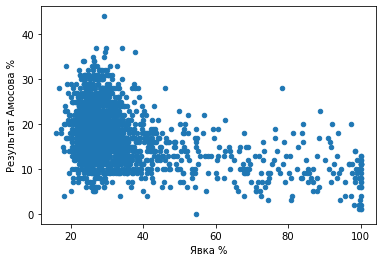

In [149]:
#6 задание
n_df = df.copy()
n_df['yavka'] = (df[3]+df[4])/df[1]*100
n_df['res_Amo'] = (df['Amo']/df[9]*100).apply(ceil)

ax = n_df.plot(x='yavka',y='res_Amo',kind='scatter')
ax.set_xlabel('Явка %')
ax.set_ylabel('Результат Амосова %')